<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2023/blob/main/10/PTE_DL10_CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

keras = tf.keras

In [3]:
temp = pd.read_csv(
    "https://raw.githubusercontent.com/karsarobert/Deep-Learning-2023/main/temp.csv", sep=';'
    ).values

series = temp

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("idő")
    plt.ylabel("hőmérséklet")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

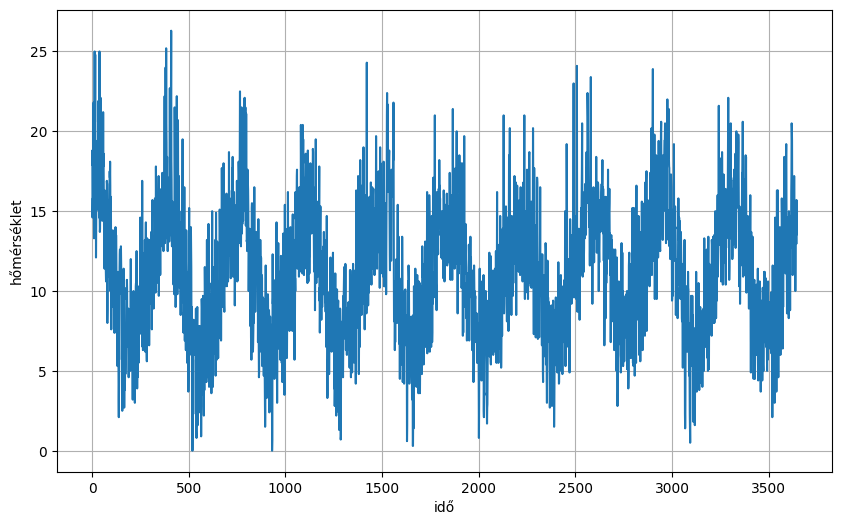

In [5]:
time = np.arange(len(series))
#time = temp[:,0].astype(np.float32)
series = temp[:,0].astype(np.float32)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True), # a return_sequences=True értéket kell beállítania az LSTM rétegek egymásra halmozásakor
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200) # kimenet méretezése
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
13/13 [==============================] - 28s 62ms/step - loss: 31.7105 - mae: 32.2105 - lr: 1.0000e-08
Epoch 2/100
13/13 [==============================] - 1s 66ms/step - loss: 30.8275 - mae: 31.3275 - lr: 1.1220e-08
Epoch 3/100
13/13 [==============================] - 1s 44ms/step - loss: 29.4964 - mae: 29.9964 - lr: 1.2589e-08
Epoch 4/100
13/13 [==============================] - 1s 41ms/step - loss: 27.7744 - mae: 28.2743 - lr: 1.4125e-08
Epoch 5/100
13/13 [==============================] - 1s 41ms/step - loss: 25.4629 - mae: 25.9628 - lr: 1.5849e-08
Epoch 6/100
13/13 [==============================] - 1s 40ms/step - loss: 22.3290 - mae: 22.8289 - lr: 1.7783e-08
Epoch 7/100
13/13 [==============================] - 1s 40ms/step - loss: 18.9639 - mae: 19.4638 - lr: 1.9953e-08
Epoch 8/100
13/13 [==============================] - 1s 40ms/step - loss: 15.9276 - mae: 16.4274 - lr: 2.2387e-08
Epoch 9/100
13/13 [==============================] - 1s 40ms/step - loss: 13.1089 - mae

(1e-08, 0.0001, 0.0, 30.0)

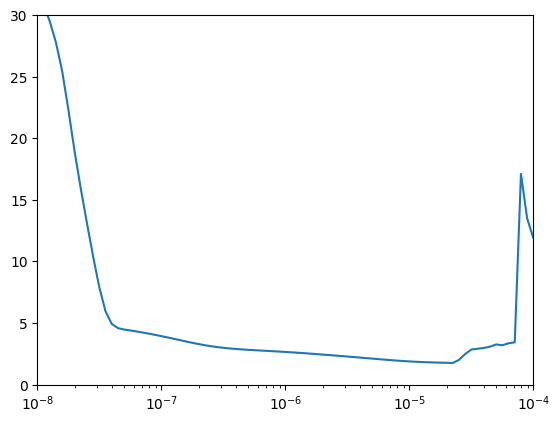

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping()
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
13/13 [==============================] - 6s 233ms/step - loss: 31.1689 - mae: 31.6660 - val_loss: 20.2169 - val_mae: 20.7151
Epoch 2/500
13/13 [==============================] - 2s 104ms/step - loss: 9.6554 - mae: 10.1476 - val_loss: 7.9589 - val_mae: 8.4557
Epoch 3/500
13/13 [==============================] - 2s 97ms/step - loss: 4.6928 - mae: 5.1745 - val_loss: 4.0460 - val_mae: 4.5210
Epoch 4/500
13/13 [==============================] - 2s 96ms/step - loss: 3.1193 - mae: 3.5897 - val_loss: 2.5493 - val_mae: 3.0158
Epoch 5/500
13/13 [==============================] - 2s 92ms/step - loss: 2.5378 - mae: 3.0008 - val_loss: 2.3130 - val_mae: 2.7774
Epoch 6/500
13/13 [==============================] - 1s 89ms/step - loss: 2.2826 - mae: 2.7427 - val_loss: 2.0516 - val_mae: 2.5083
Epoch 7/500
13/13 [==============================] - 2s 149ms/step - loss: 2.1206 - mae: 2.5763 - val_loss: 1.9346 - val_mae: 2.3913
Epoch 8/500
13/13 [==============================] - 2s 124ms/step -

In [23]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

103/103 [==============================] - 2s 17ms/step


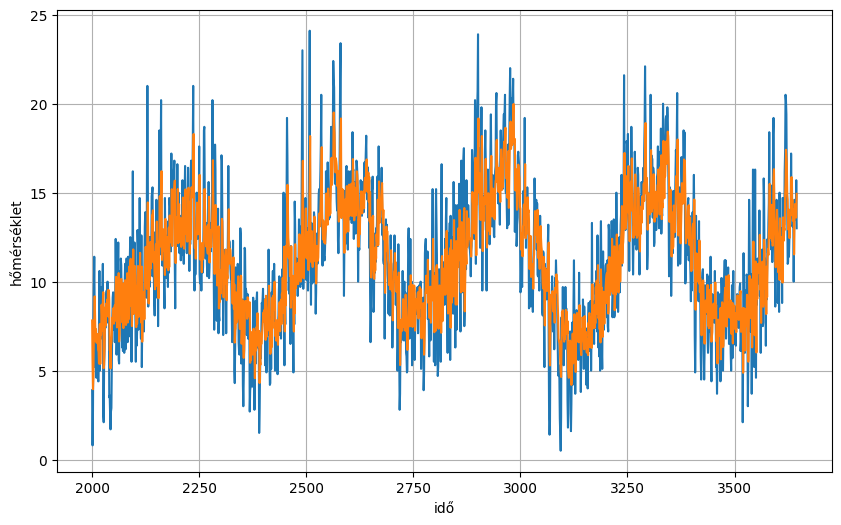

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8311967

## Fully Convolutional Forecasting

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
13/13 [==============================] - 6s 110ms/step - loss: 10.2358 - mae: 10.7347 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - 1s 29ms/step - loss: 9.9583 - mae: 10.4569 - lr: 1.0798e-04
Epoch 3/100
13/13 [==============================] - 1s 30ms/step - loss: 9.5329 - mae: 10.0312 - lr: 1.1659e-04
Epoch 4/100
13/13 [==============================] - 1s 29ms/step - loss: 8.8656 - mae: 9.3635 - lr: 1.2589e-04
Epoch 5/100
13/13 [==============================] - 1s 30ms/step - loss: 7.7854 - mae: 8.2825 - lr: 1.3594e-04
Epoch 6/100
13/13 [==============================] - 1s 30ms/step - loss: 5.9761 - mae: 6.4680 - lr: 1.4678e-04
Epoch 7/100
13/13 [==============================] - 1s 30ms/step - loss: 3.5261 - mae: 3.9991 - lr: 1.5849e-04
Epoch 8/100
13/13 [==============================] - 1s 29ms/step - loss: 2.8311 - mae: 3.2941 - lr: 1.7113e-04
Epoch 9/100
13/13 [==============================] - 1s 31ms/step - loss: 2.6660 - mae: 3.1268 - lr

(0.0001, 0.1, 0.0, 30.0)

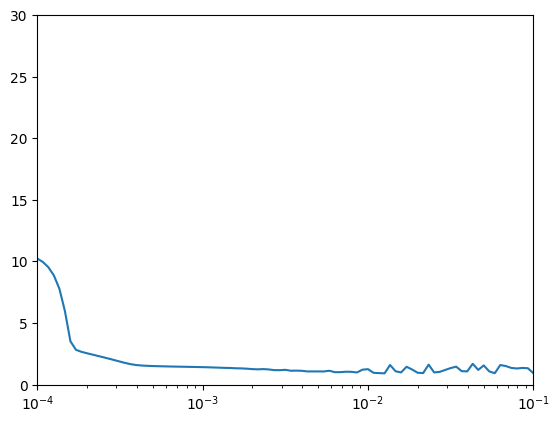

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
13/13 [==============================] - 5s 163ms/step - loss: 10.0595 - mae: 10.5583 - val_loss: 10.3039 - val_mae: 10.8036
Epoch 2/500
13/13 [==============================] - 1s 88ms/step - loss: 9.6444 - mae: 10.1428 - val_loss: 9.7772 - val_mae: 10.2766
Epoch 3/500
13/13 [==============================] - 1s 78ms/step - loss: 9.0227 - mae: 9.5205 - val_loss: 8.9348 - val_mae: 9.4330
Epoch 4/500
13/13 [==============================] - 1s 80ms/step - loss: 7.9910 - mae: 8.4880 - val_loss: 7.5180 - val_mae: 8.0159
Epoch 5/500
13/13 [==============================] - 1s 88ms/step - loss: 6.3908 - mae: 6.8842 - val_loss: 5.4814 - val_mae: 5.9712
Epoch 6/500
13/13 [==============================] - 1s 81ms/step - loss: 4.3716 - mae: 4.8533 - val_loss: 3.2760 - val_mae: 3.7480
Epoch 7/500
13/13 [==============================] - 2s 154ms/step - loss: 2.9555 - mae: 3.4207 - val_loss: 2.7226 - val_mae: 3.1859
Epoch 8/500
13/13 [==============================] - 2s 103ms/step -

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

In [18]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

103/103 [==============================] - 2s 16ms/step


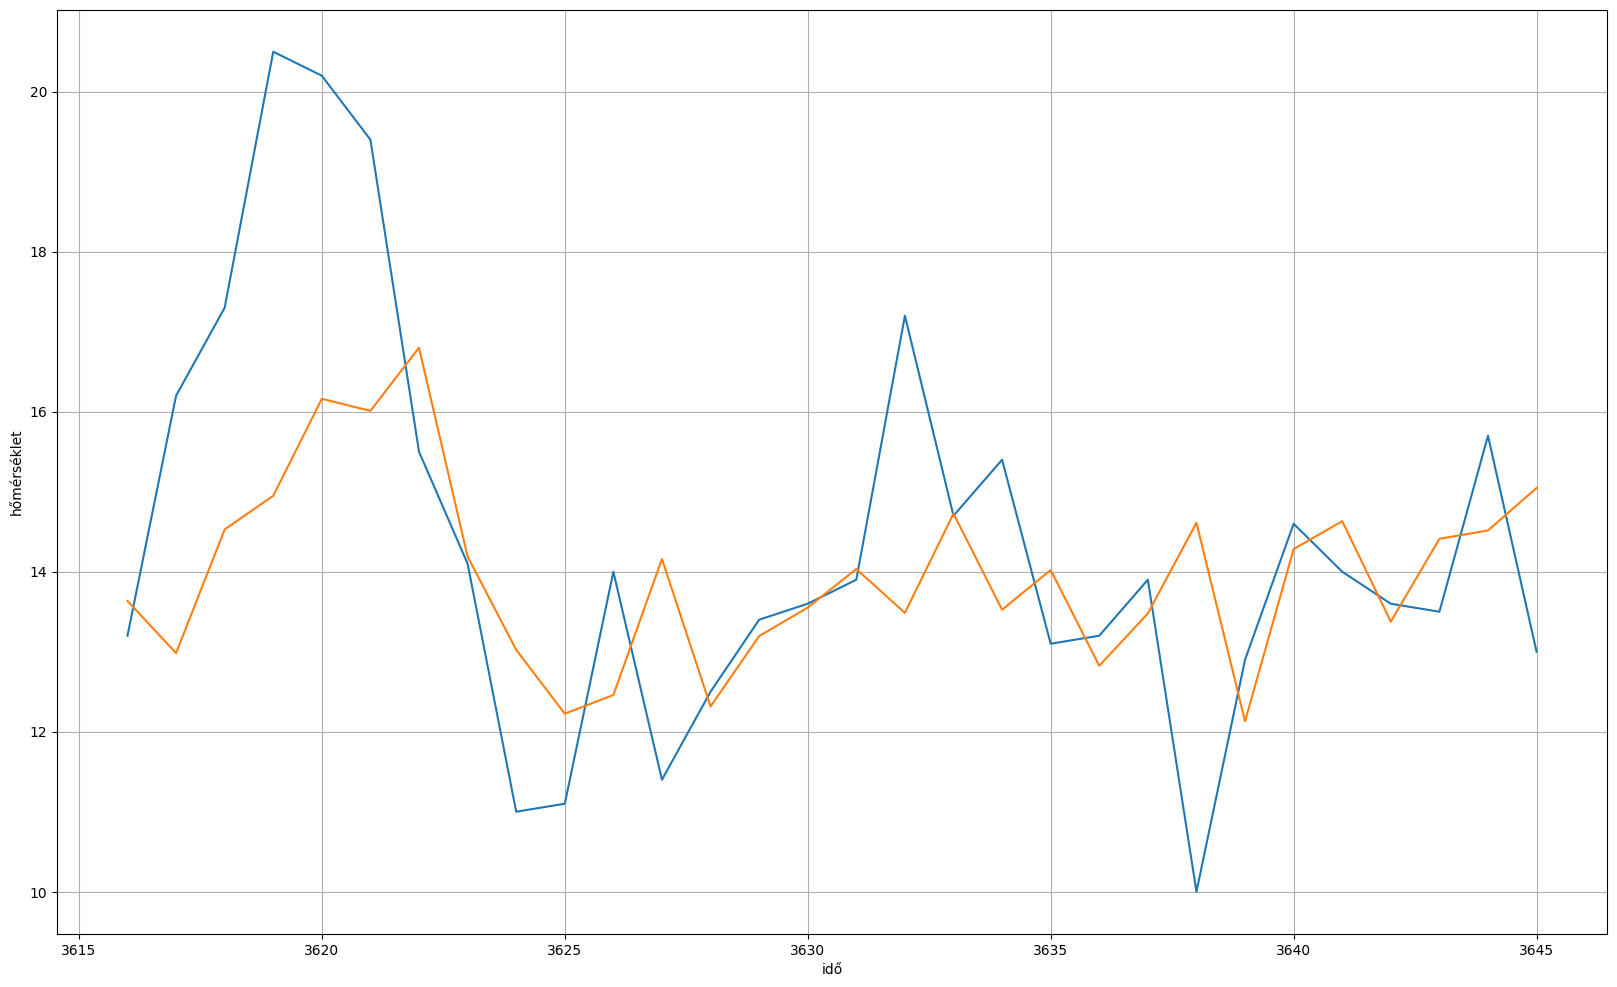

In [19]:
plt.figure(figsize=(20, 12))
plot_series(time_valid[-30:], x_valid[-30:])
plot_series(time_valid[-30:], cnn_forecast[-30:])

In [20]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

1.8530205